# Performance of Classification tasks pre-oversampling

The purpose of this notebook is to train and evaluate various models on the data prior to using any techniques to deal with the imbalance in the classes.

In [ ]:
import pandas as pd
import numpy as np
import os
import kagglehub

In [ ]:
# Import dataset
df = kagglehub.dataset_load(
    kagglehub.KaggleDatasetAdapter.PANDAS,
    #"unsdsn/world-happiness/versions/1",
    "fedesoriano/stroke-prediction-dataset",
    "healthcare-dataset-stroke-data.csv",
)

# drop unnecessary column
df = df.drop("id", axis = 1)

Using Colab cache for faster access to the 'stroke-prediction-dataset' dataset.


In [ ]:
# process data
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split

SEED = 0

# categorical and numerical columns
num_cols = ["age","avg_glucose_level", "bmi"]
cat_cols = df.select_dtypes(include=['object']).columns.tolist()
categorical_features = cat_cols  + ["hypertension", "heart_disease"]


# Define column transformers inside a pipeline
categorical_transformer = make_pipeline(OneHotEncoder(handle_unknown="ignore"))
numerical_transformer = make_pipeline(SimpleImputer(strategy="mean"), StandardScaler())

# preprocessor  mean imputer and one-hot encoder
preprocessor = ColumnTransformer(
    transformers=[
        ("num_imputer", numerical_transformer, num_cols),
        ("cat", categorical_transformer, categorical_features)
    ],
    remainder="drop"
)



# train test split
trainer, tester = train_test_split(df, train_size=0.8, stratify=df.stroke, random_state=SEED)
print(f'Train set shape:{trainer.shape}\nTest set shape:{tester.shape}')


# # fit only on the trainset
# preprocessor.fit(trainer)

# # apply to both sets
# train_imputed = preprocessor.transform(trainer)
# test_imputed = preprocessor.transform(tester)


Train set shape:(4088, 11)
Test set shape:(1022, 11)


In [ ]:
# defune necessary imports
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, mutual_info_score, accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.preprocessing import StandardScaler



In [ ]:
def save_df(df, name):
  df.to_csv(name)

In [ ]:
# ensure similar ratios are in training and test splits.
def show_value_ratios(arr):
  """
    Given an array or datafram column show the percentage
    that each unique value makes up of the array.
  """
  values, counts = np.unique(arr, return_counts=True)
  length = len(arr)
  for val, count in zip(values, counts):
    percentage = count / length * 100
    print(f"class {val}: {percentage:.2f}%")


y = df['stroke']

x_train = trainer.drop('stroke', axis = 1)
x_test = tester.drop('stroke', axis = 1)

y_train = trainer.stroke
y_test = tester.stroke


print("Percentages in the data: ")
show_value_ratios(y)
print()
print("Percentages in the training data: ")
show_value_ratios(y_train)
print()
print("Percentages in the test data: ")
show_value_ratios(y_test)


Percentages in the data: 
class 0: 95.13%
class 1: 4.87%

Percentages in the training data: 
class 0: 95.13%
class 1: 4.87%

Percentages in the test data: 
class 0: 95.11%
class 1: 4.89%


# Making a Pipeline for standardization

We can prevent common mistakes by using a pipeline to handle standardization for us.


https://scikit-learn.org/stable/common_pitfalls.html

In [ ]:
# make a pipeline to standardize the data
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, \
                            ConfusionMatrixDisplay, classification_report, \
                            recall_score, balanced_accuracy_score




## Logistic Regression Model

In [ ]:
lr = LogisticRegression()

pipeline = make_pipeline(preprocessor, lr)


# use cross validation to assess accuracy

kf = StratifiedKFold(n_splits=5, random_state=None)
avg_accuracy = 0


for train_indices, val_indices in kf.split(x_train, y_train):


  # variables for training each fold
  x_train_ = x_train.iloc[train_indices]
  y_train_ = y_train.iloc[train_indices]
  # variables for validation in each fold
  x_val = x_train.iloc[val_indices]
  y_val = y_train.iloc[val_indices]

  pipeline.fit(x_train_, y_train_)
  predictions = pipeline.predict(x_val)
  avg_accuracy += accuracy_score(y_val, predictions)

avg_accuracy = avg_accuracy / kf.get_n_splits()

print(avg_accuracy)


#scores = cross_validate(pipeline, x_train, y_train, scoring="accuracy")

#scores

0.9508318045925069


Accuracy is not a good metric to use for an imbalanced data set. In this example, the accuracy is high, yet, the model was unable to correctly predict any of the samples in the minority class as can be seen in the confusion matrix below.

Text(0.5, 1.0, 'Confusion Matrix of Last Fold')

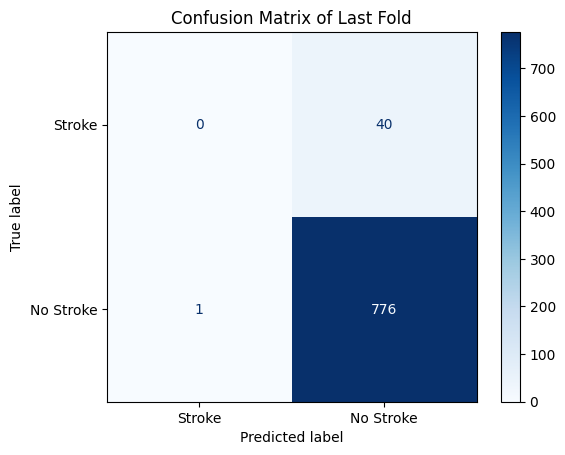

In [ ]:
import matplotlib.pyplot  as plt

disp = ConfusionMatrixDisplay.from_estimator(
    pipeline,
    x_val,
    y_val,
    labels = [1, 0],
    display_labels=["Stroke", "No Stroke"],
    cmap=plt.cm.Blues,


)
disp.ax_.set_title("Confusion Matrix of Last Fold")

No samples of the positive class were correctly predicted. In contrast, all of the samples of the negative class were correctly identified.


It seems like this logistic regression model chooses to always predict that a patient will not have a stroke, since the loss can be minimized to a a great extent by using this method, and the number of times it classifies stroke patients as non-stroke patients is so small that it has a negligible sway on the loss function.



It can be seen that we need better metrics to get a better picture of what our classifier's performance actually is.
One such measure is recall. which is TP / (TP + FN). This is the ratio of correctly identified samples in the positive class to all samples in the positive class. In our case this would tell us the proportion of correctly identified samples with a stroke out of all patients with a stroke.

Here are three evaluation metrics run using cross validation:
1. accuracy
2. recall
3. balanced accuracy

In [ ]:
def evaluate_cv(estimator, x_train, y_train, scoring = ["accuracy", "recall", "balanced_accuracy", "f1"]):
  cv_results = cross_validate(estimator, x_train, y_train, scoring=scoring)
  # print average of tests
  for k in cv_results.keys():
    if k.startswith("test"):
      avg = np.mean(cv_results[k])
      print(f"average {k}: {avg:.4f}")

evaluate_cv(pipeline, x_train, y_train)

average test_accuracy: 0.9508
average test_recall: 0.0000
average test_balanced_accuracy: 0.4997
average test_f1: 0.0000


## Weighted Logistic Regression

we can use weights to make the minority class more important when the model is being trained.

In [ ]:
from sklearn.linear_model import LogisticRegressionCV

lrcv = LogisticRegressionCV(scoring="recall", class_weight="balanced")
pipeline = make_pipeline(preprocessor, lrcv)
pipeline.fit(x_train, y_train)

means = np.mean(lrcv.scores_[1], axis = 0)
means
print("average recall using best value of C: ", np.max(means))


average recall using best value of C:  0.8385897435897436


In [ ]:
lrcv.C_

array([0.00077426])

In [ ]:
evaluate_cv(pipeline, x_train, y_train)

average test_accuracy: 0.7184
average test_recall: 0.8336
average test_balanced_accuracy: 0.7731
average test_f1: 0.2241


We are trying to increase the performance of the model in correctly prediciting the minority class. Adjusting the weights and using logistic regression results in a trade off of accuracy between the two classes. That is to say, as the recall of the minority class increases, the recall of the majority class decreases.
In our case, this means that as we improve our recognition of patients who suffered a stroke we undermine our  ability to correctly classify the patients who have not had a stroke.

# Tree Classifiers

As expected, a decision tree performs better since it can handle categorical data better than base logistic regression can.

In [ ]:
from sklearn.tree import DecisionTreeClassifier

tree_classifier = make_pipeline(preprocessor, DecisionTreeClassifier())


evaluate_cv(tree_classifier, x_train, y_train)

average test_accuracy: 0.9105
average test_recall: 0.1759
average test_balanced_accuracy: 0.5620
average test_f1: 0.1603


## Random Forest

In [ ]:
# try random forest
from sklearn.ensemble import RandomForestClassifier
predictor = make_pipeline(preprocessor, RandomForestClassifier())
evaluate_cv(predictor, x_train, y_train)

average test_accuracy: 0.9499
average test_recall: 0.0150
average test_balanced_accuracy: 0.5063
average test_f1: 0.0277


The random forest classifier does a lot worse than a decision tree.

# KNN

In [ ]:
knn = make_pipeline(preprocessor, KNeighborsClassifier())
evaluate_cv(knn, x_train, y_train)

average test_accuracy: 0.9481
average test_recall: 0.0100
average test_balanced_accuracy: 0.5031
average test_f1: 0.0182


## Gaussian Naive Bayes

In [ ]:
# model without scaling features
gaussian = make_pipeline(preprocessor, GaussianNB())
evaluate_cv(gaussian, x_train, y_train)

average test_accuracy: 0.3980
average test_recall: 0.9699
average test_balanced_accuracy: 0.6693
average test_f1: 0.1360


The difference between using scaled vs unscaled features in the Gaussian model is extreme. When the features aren't scaled, the positive ("stroke") class is favored and we get a high recall while the true negative rate (or the recall of the negative class) suffers.

In the model with scaled features, we see the opposite.

## End of section 2

The best model was logistic regression with weighted classes. This will be the model that will serve for comparison against models trained after applying SMOTE.

# Sources

https://scikit-learn.org/stable/common_pitfalls.html